This Notebook will build on the exploratory data analysis we performed on the Zoo Animal dataset.

To follow the tutorial read each section of text and then run the Python code below the section.





The following commands connect to GDrive. Running the commands should present an accounts.google.com link. Click to open it in a browser window (where you may be prompted to login in to your Google account and authorise Colabs to access your files) and copy the authorisation code it gives you (there's a little 'double rectangle' which you can click to copy). Then paste the code in the space below, where it says "Enter your authorization code":

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Import the libraries used by this tutorial. Libraries contain programmes that people have already written to save you re-inventing the wheel.

In [ ]:
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score

Test that you can access the data files for this tutorial. After running this cell you should see two files in a list:
 ['zoo.csv','zoo.clean.csv']

In [ ]:
data_dir = '/content/gdrive/My Drive/MLC/Session 2/Data/'
os.listdir(data_dir)

['us_census_1994.txt', 'zoo.csv', 'zoo.gsheet']

Load the zoo data as we did last time

In [ ]:
zoo_data = pd.read_csv(data_dir + 'zoo.csv', header=None)
zoo_data.columns = ['animalname','hair','feathers','eggs','milk','airborne','aquatic','predator','toothed','backbone', \
                    'breathes','venomous','fins','legs','tail','domestic','catsize','animalclass']
zoo_data.head(1)

,animalname,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,animalclass
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1


Before starting with the Nearest Neighbours algorithm, let's think back to the paper exercise about decision boundaries. Without explicitly deriving a boundary, nearest neighbours relies on data of different classes being clearly separated. With 2 feature columns we could easily plot points on a scatterplot and see for ourselves, but the data obviously becomes impossible to visualise beyond 3 dimensions (columns).

However, there is a set of techniques known as Dimensionality Reduction which combine features in such a way as to reduce the number of columns. This means we can turn our 16 columns into 2 and then visualise them.

**Run the following code and examine the scatterplot.** You should see a reasonable amount of separation between the colours. This is a good sign that this algorithm will work quite well.

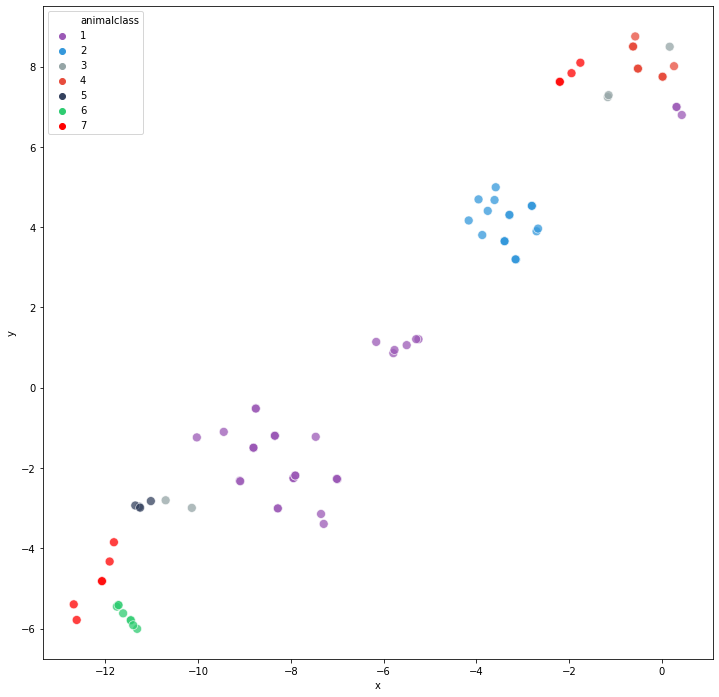

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

zoo_all = zoo_data.drop(['animalclass', 'animalname'], axis = 1)
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)
pca_result = tsne.fit_transform(zoo_all)
#pca_result
pca_result = pd.DataFrame({'x': pca_result[:,0], 'y': pca_result[:,1], 'animalclass': zoo_data['animalclass']})
plt.figure(figsize=(12,12))
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34415e", "#2ecc71", "#FF0000"]
sns.scatterplot(x="x", y="y",
    hue="animalclass",
    palette=sns.color_palette(flatui),
    data=pca_result,
    #legend="full",
    alpha=0.75, s = 80
)

We will now create a stratified training set and to make this a bit more challenging we will use only 20% of the data for training. Run the code below which creates the training and test datasets, and outputs histograms of counts by class. **Take a moment to look at the counts of each animal class in the Training data.** (Note the difference in Y-axis scales on each graph)

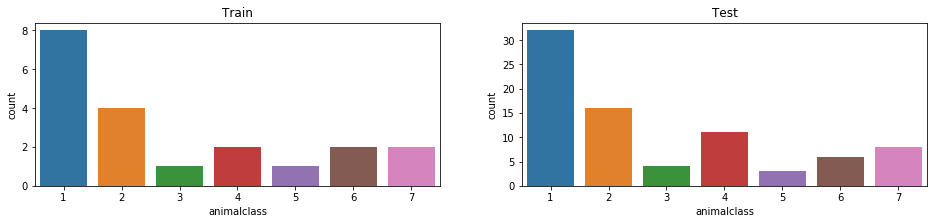

In [ ]:
TRAIN_SIZE = 0.2
zoo_train, zoo_test = train_test_split(zoo_data, train_size = TRAIN_SIZE, stratify = zoo_data.animalclass)
fig, ax =plt.subplots(1,2, figsize=(16, 3))
sns.countplot(zoo_train['animalclass'], ax=ax[0])
sns.countplot(zoo_test['animalclass'], ax=ax[1])
ax[0].set_title("Train")
ax[1].set_title("Test")
plt.show()

The following code uses the K Neighbours Classifier from scikit-learn. This classifier is often abbreviated as KNN (K Nearest Neighbours). To use KNN we load the numerical features of the training data (X_train) and the class labels (y_train) into the algorithm and run the 'fit' function. It will position each row of data into a multi-dimensional space depending on how many features there are. If we only have two feature columns they will be placed in a 2D space, like a scatter plot.
There are a number of parameters we can pass into KNN when we set it up but the most important one is the "Number of Neigbours" (n_neighbors). Here we have set it to 3. This is the **K** of KNN. Once the training data is loaded we are ready to make predictions.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
K = 3  # K = Number of Neighbours
X_train = zoo_train.drop(['animalclass', 'animalname'], axis = 1)
y_train = zoo_train['animalclass']
knn = KNeighborsClassifier(n_neighbors=K).fit(X_train, y_train)

To make a prediction for an individual record we take the same set of features (in the same order, this is important!!) and pass them into the predict function. What happens next is that KNN finds the K (in our case 3) training records which are geometrically closest to the one we're trying to predict. The most common method for measuring the distance is the Euclidean distance (named after the Ancient Greek mathematician Euclid, but think of Pythagoras and measuring the hypotenuse of a triangle).

It will then look at the labels of the K nearest records and choose the majority label. This is the predicted label. In the case of a tie there are methods involving weighting the nearest neighbours by distance but those are built into the algorithm and we won't go into them further here.

The following code will make predictions for the test data and also create a results table for use later on. You won't see any output when it runs, it just creates data to be used further down.

In [ ]:
X_test = zoo_test.drop(['animalclass','animalname'], axis = 1)
y_test = zoo_test['animalclass']
y_test_pred = knn.predict(X_test)
y_train_pred = knn.predict(X_train)
zoo_test_pred = zoo_test.copy(deep=True)
zoo_test_pred["predicted"] = y_test_pred

We now draw confusion matrices for training and test to examine the results. **Look at the rows labelled 2 and 4.** You should see that the predictions are always wrong (there are zeros on the diagonals that starts in the top left). **Is this the case for any other classes?**

Now think back to the histogram of training records by animal class above, and also remember that we're using 3 nearest neighbours. **Why do you think it is always incorrect for these records?**.

In light of this, **go back to where you set up the KNN algorithm and change K to 1**. You will also need to rerun the code that does the prediction and then finally rerun the confusion matrix. 

**Look again at classes 2 and 4 in the test matrix. Are they better? Why?**

**What has happened to the training error?**
**Why do you think this has happened?**
**What is this an example of?** (think back to the first tutorial of this session)

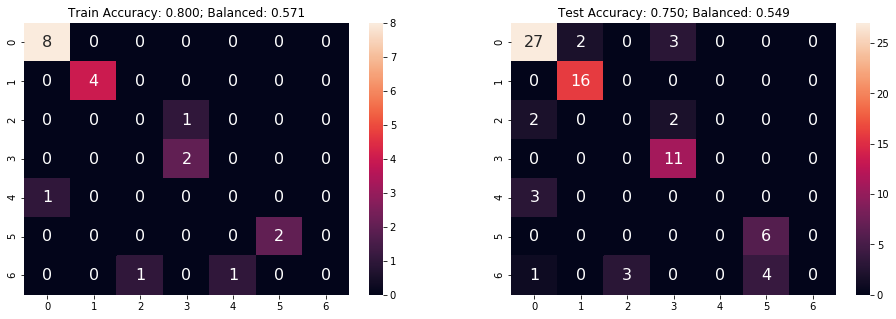

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, y_train_pred, normalize=None), range(7), range(7)), annot=True, annot_kws={"size": 16}, ax=ax[0])
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_test_pred, normalize=None), range(7), range(7)), annot=True, annot_kws={"size": 16}, ax=ax[1])
ax[0].set_title("Train Accuracy: %0.3f; Balanced: %0.3f" % (accuracy_score(y_train, y_train_pred), balanced_accuracy_score(y_train, y_train_pred)))
ax[1].set_title("Test Accuracy: %0.3f; Balanced: %0.3f" % (accuracy_score(y_test, y_test_pred), balanced_accuracy_score(y_test, y_test_pred)))
plt.show()

This piece of code lets us look at incorrectly classified rows. **Change the TRUE_VAL variable (1 to 7) to see records which have been incorrectly classified.** Use the Test confusion matrix to guide you. If the row is non-zero apart from the diagonal then it is all correct.

In [ ]:
TRUE_VAL = 1  # Change this variable. Valid values are between 1 and 7
zoo_test_pred[(y_test == TRUE_VAL) & (y_test_pred != TRUE_VAL)]

,animalname,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,animalclass,predicted
19,dolphin,0,0,0,1,0,1,1,1,1,1,0,1,0,1,0,1,1,4
73,seal,1,0,0,1,0,1,1,1,1,1,0,1,0,0,0,1,1,4
65,porpoise,0,0,0,1,0,1,1,1,1,1,0,1,0,1,0,1,1,4
92,vampire,1,0,0,1,1,0,0,1,1,1,0,0,2,1,0,0,1,2
27,fruitbat,1,0,0,1,1,0,0,1,1,1,0,0,2,1,0,0,1,2


If you take the class that a row has been incorrectly predicted as (last column above) you can then use the following code to views training rows with that class.
**Have a look at one or two examples and see if you can understand the reason for the prediction.** The easiest way to do this is just eyeball the values in the table above and below and see how similar the rows are.

In [ ]:
zoo_train[zoo_train["animalclass"] == 4]

,animalname,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,animalclass
60,piranha,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
85,stingray,0,0,1,0,0,1,1,1,1,0,1,1,0,1,0,1,4


We can also ask the KNN algorithm to give us the K nearest neighbours that it found. We will go back to using K = 3 for this example. The "porpoise" was misclassified as a 4 so we will use that. Run this code to isolate that row as an example.

In [ ]:
test_row = X_test[zoo_test["animalname"]  == "porpoise"]
test_row

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
65,0,0,0,1,0,1,1,1,1,1,0,1,0,1,0,1


Now use KNN to find the 3 nearest neighbours. As you did above, **compare the porpoise records with the results of the table below.**

In [ ]:
NN = knn.kneighbors(test_row, n_neighbors = 3, return_distance = True)
zoo_train.iloc[NN[1].ravel()]

,animalname,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,animalclass
60,piranha,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
85,stingray,0,0,1,0,0,1,1,1,1,0,1,1,0,1,0,1,4
74,sealion,1,0,0,1,0,1,1,1,1,1,0,1,2,1,0,1,1


How do we choose the best value of K? We try a range of them and pick the best one. This is often where a lot of the work goes into Machine Learning, it is an iterative process of refining algorithms and data to get the best results.

Let's build a graph of results for different values of K. We will evaluate against the test dataset and use the balanced accuracy as a metric.

**What is the best value of K?**

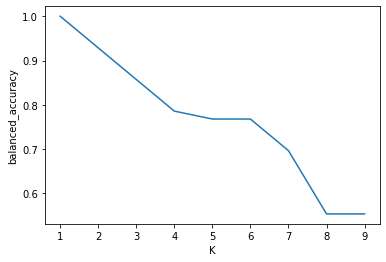

In [ ]:
knn_results = pd.DataFrame(columns = ['K', 'balanced_accuracy'])
i = 0
for n in range(1,10):
  knn = KNeighborsClassifier(n_neighbors=n, algorithm='auto').fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  acc = balanced_accuracy_score(y_test, y_pred)
  knn_results.loc[i] = [n, acc]
  i += 1

sns.lineplot(y = knn_results['balanced_accuracy'], x = knn_results['K'])

That was the best value for this dataset, but what if we change the amount of training data we use? The following code loops through 4 different sizes of training data (20% to 80% of the whole dataset)

**Examine the 4 curves produced**

**Run the graph several times. Is the graph the same every time?**

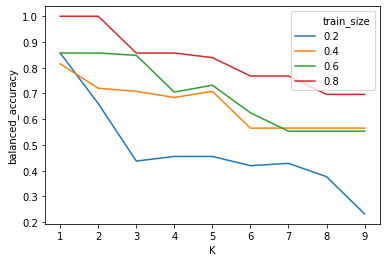

In [ ]:
knn_results = pd.DataFrame(columns = ['train_size','K','balanced_accuracy'])
i = 0
for T in range(2,10,2):
    zoo_train, zoo_test = train_test_split(zoo_data, train_size = T/10, stratify = zoo_data.animalclass)
    X_train = zoo_train.drop(['animalclass', 'animalname'], axis = 1)
    y_train = zoo_train['animalclass']
    X_test = zoo_test.drop(['animalclass','animalname'], axis = 1)
    y_test = zoo_test['animalclass']

    for n in range(1,10):
        knn = KNeighborsClassifier(n_neighbors=n, algorithm='auto').fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        acc = balanced_accuracy_score(y_test, y_pred)
        i += 1
        knn_results.loc[i] = [T/10, n, acc]

knn_results['train_size'] = knn_results.train_size.astype('category')
sns.lineplot(y = knn_results['balanced_accuracy'], x = knn_results['K'], hue = knn_results['train_size'])

Each time we run the code above we get different results. Why might this be? Every time we run it, we are using different data for training and test. With a small dataset like this, and particularly for the smaller classes, it might be luck of the draw as to whether training is representative of test. Remember the porpoise?

In Session 3 we will look at ways to handle this problem.

We've compared KNN results with a variety of parameters but how can we be sure it is the right tool for the job?

Well, we can compare it to other algorithms. Let's see how it does against a Decision Tree and Logistic Regression (which we haven't looked at yet).

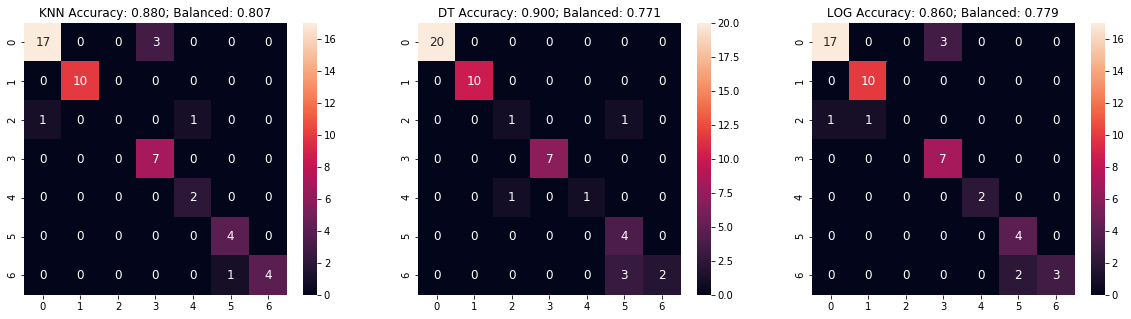

In [ ]:
zoo_train, zoo_test = train_test_split(zoo_data, train_size = 0.5, stratify = zoo_data.animalclass)
X_train = zoo_train.drop(['animalclass', 'animalname'], axis = 1)
y_train = zoo_train['animalclass']
X_test = zoo_test.drop(['animalclass','animalname'], axis = 1)
y_test = zoo_test['animalclass']
knn = KNeighborsClassifier(n_neighbors=1, algorithm='auto').fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

from sklearn import tree
decision = tree.DecisionTreeClassifier()                            # Set up the Decision Tree Classifier function
decision = decision.fit(X_train, y_train) 
y_pred_dt = decision.predict(X_test)

from sklearn import linear_model
logit = linear_model.LogisticRegression()                            # Set up the Decision Tree Classifier function
logit = logit.fit(X_train, y_train) 
y_pred_log = logit.predict(X_test)

fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_knn, normalize=None), range(7), range(7)), annot=True, annot_kws={"size": 12}, ax = ax[0])
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_dt, normalize=None), range(7), range(7)), annot=True, annot_kws={"size": 12}, ax=ax[1])
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_log, normalize=None), range(7), range(7)), annot=True, annot_kws={"size": 12}, ax=ax[2])
ax[0].set_title("KNN Accuracy: %0.3f; Balanced: %0.3f" % (accuracy_score(y_test, y_pred_knn), balanced_accuracy_score(y_test, y_pred_knn)))
ax[1].set_title("DT Accuracy: %0.3f; Balanced: %0.3f" % (accuracy_score(y_test, y_pred_dt), balanced_accuracy_score(y_test, y_pred_dt)))
ax[2].set_title("LOG Accuracy: %0.3f; Balanced: %0.3f" % (accuracy_score(y_test, y_pred_log), balanced_accuracy_score(y_test, y_pred_log)))

plt.show()

You will again find that you get different results each time you run this but KNN seems to be at least competitive sometimes better than the other two. It appears that it is particularly more consistent on the balanced score than overall accuracy.



We will now change datasets and load the census data from Session 1. Have a quick look at the columns to refresh your memory of it.

In [ ]:
census_data = pd.read_csv(data_dir + 'us_census_1994.txt', delimiter="\t")
census_data.loc[(census_data['workclass'].str.contains('\?')), 'workclass'] = 'Unknown-Workclass'
one_hot_census = pd.get_dummies(census_data[['education', 'maritalstatus', 'relationship', 'race', 'sex', 'workclass','occupation', 'nativecountry', 'salary']],drop_first=True)
one_hot_census = census_data.join(one_hot_census)
#one_hot_census = one_hot_census.drop(['education', 'maritalstatus', 'relationship', 'race', 'sex', 'workclass','occupation', 'nativecountry'], axis=1)
one_hot_census.head(3)

,age,workclass,fnlwgt,education,educationnum,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


**We will run this final demo on the big screen as it takes a while to run, so stop here**

The code below will demonstrate another pre-processing step when preparing data for ML, which is called Scaling. The idea behind scaling is to put all of the columns into the same statistical distribution. It isn't essential but can produce better results, and some ML algorithms can misbehave without this step.

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.StandardScaler()

census_train, census_test = train_test_split(one_hot_census, train_size = 0.05, stratify = census_data.salary)
feature_columns = ['age', 'workclass_', 'educationnum', 'occupation_', 'maritalstatus_', 'relationship_', 'race_', 'sex_', 'nativecountry_', 'capitalgain', 'capitalloss', 'hoursperweek']
#feature_columns = ['educationnum', 'maritalstatus_', 'capitalgain', 'age', 'occupation_']
feature_columns = [j for i in feature_columns for j in census_train.columns if i == j[0:len(i)]]
X_train = census_train[feature_columns]
X_train_scaled = min_max_scaler.fit_transform(X_train)
y_train = census_train['salary_ >50K']

X_test = census_test[feature_columns]
X_test_scaled = min_max_scaler.fit_transform(X_test)
y_test = census_test['salary_ >50K']

Now we will run the KNN algorithm several times for both the original data and the scaled version to see what difference it makes. We will also compare it to the Decision Tree (out of the box with no parameter tuning).

**Compare the accuracy curves of KNN and KNN Scaled in relation to the Decision Tree benchmark**

The final aspect of KNN we will look at is the effect of removing some columns. **Remove the comment ('#') from in front of the shorter list of feature_columns in the code above.** Rerun that code and then rerun the graphs below.

In [ ]:
from sklearn import tree
decision = tree.DecisionTreeClassifier(class_weight='balanced')                            # Set up the Decision Tree Classifier function
decision = decision.fit(X_train, y_train) 
y_pred_dt = decision.predict(X_test)
dt_accuracy = balanced_accuracy_score(y_test, y_pred_dt)

knn_results = pd.DataFrame(columns = ['Alg', 'K', 'balanced_accuracy'])
i = 0
for n in [1,3,5,10,15,30,40]:
  knn_std = KNeighborsClassifier(n_neighbors=n, algorithm='auto').fit(X_train, y_train)
  knn_scaled = KNeighborsClassifier(n_neighbors=n, algorithm='auto').fit(X_train_scaled, y_train)
  y_pred_std = knn_std.predict(X_test)
  y_pred_scaled = knn_scaled.predict(X_test_scaled)
  acc_std = balanced_accuracy_score(y_test, y_pred_std)
  acc_scaled = balanced_accuracy_score(y_test, y_pred_scaled)
  knn_results.loc[i] = ['KNN', n, acc_std]
  i += 1
  knn_results.loc[i] = ['DT', n, dt_accuracy]
  i += 1
  knn_results.loc[i] = ['KNN Scaled', n, acc_scaled]
  i += 1

sns.lineplot(y = 'balanced_accuracy', x = 'K', hue = 'Alg', data = knn_results, palette=['red','blue','black'])

Why was KNN worse than the Decision Tree but now potentially better? The KNN algorithm suffers from a phenomenon called "The Curse of Dimensionality". This basically means that if the data has lots of features (columns), the nearest neighbours can actually start to be geometrically very far away and therefore potentially quite different records. By reducing the number of features we can improve the accuracy of the algorithm.

That's the end of this tutorial in which you have learned the following about the K Nearest Neighbours algorithm:

1.   How to select the best value for K
2.   The effect of Scaling the data

1.   The perils of The Curse of Dimensionality
2.   How to visualise multi-dimensional data













